<a href="https://colab.research.google.com/github/UsagiUG/PCD_Assignment02/blob/main/Tugas_PACD_Convolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from PIL import Image
import numpy as np
import requests
from io import BytesIO
import matplotlib.pyplot as plt

# test

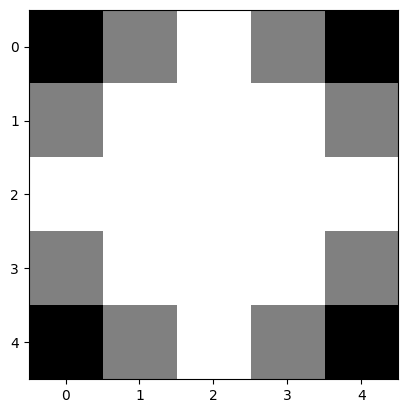

In [43]:
gs_img = np.array([
    [0, 128, 255, 128, 0],
    [128, 255, 255, 255, 128],
    [255, 255, 255, 255, 255],
    [128, 255, 255, 255, 128],
    [0, 128, 255, 128, 0]
])
plt.imshow(gs_img, cmap="gray")
plt.show()

In [45]:
# kernel = np.array([
#     [0,1,0],
#     [1,-4,1],
#     [0,1,0]
# ])

kernel = np.array([
    [0,0,0],
    [0,0,1],
    [0,0,0]
])

In [54]:
def convolution(gs_img, kernel):
  new_img = np.zeros_like(gs_img, dtype=np.float32)

  pad_y = kernel.shape[0] // 2
  pad_x = kernel.shape[1] //2
  padded = np.zeros((gs_img.shape[0] + 2*(kernel.shape[0]//2), gs_img.shape[1] + 2*(kernel.shape[1]//2)), np.uint8)

  for img_y in range(gs_img.shape[0]):
    for img_x in range(gs_img.shape[1]):
      padded[img_y+pad_y, img_x+pad_x] = gs_img[img_y, img_x]

  for img_y in range(gs_img.shape[0]):
    for img_x in range(gs_img.shape[1]):
      for kernel_y in range(kernel.shape[0]):
        for kernel_x in range(kernel.shape[1]):
          new_img[img_y, img_x] += padded[img_y+kernel_y, img_x+kernel_x] * kernel[kernel_y, kernel_x]

  new_img = np.clip(new_img, 0, 255).astype(np.uint8)
  return new_img

In [56]:
import numpy as np

def convolution(gs_img, kernel):
    # Flip kernel (true convolution, not correlation)
    kernel = np.flipud(np.fliplr(kernel))

    # Padding
    pad_y = kernel.shape[0] // 2
    pad_x = kernel.shape[1] // 2
    padded = np.pad(gs_img, ((pad_y, pad_y), (pad_x, pad_x)), mode='constant', constant_values=0)

    # Output image (float to avoid overflow)
    new_img = np.zeros_like(gs_img, dtype=np.float32)

    # Convolution
    for img_y in range(gs_img.shape[0]):
        for img_x in range(gs_img.shape[1]):
            region = padded[img_y:img_y+kernel.shape[0], img_x:img_x+kernel.shape[1]]
            new_img[img_y, img_x] = np.sum(region * kernel)

    # Clip to [0,255] and convert back to uint8
    new_img = np.clip(new_img, 0, 255).astype(np.uint8)
    return new_img


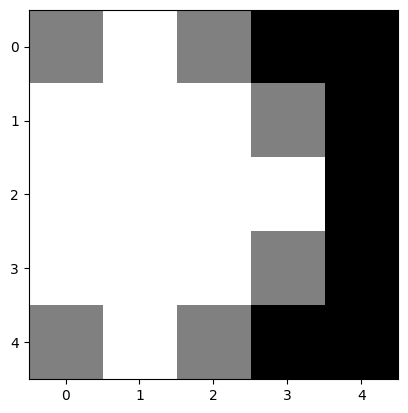

In [52]:
new_img = convolution(gs_img, kernel)
plt.imshow(new_img, cmap="gray")
plt.show()

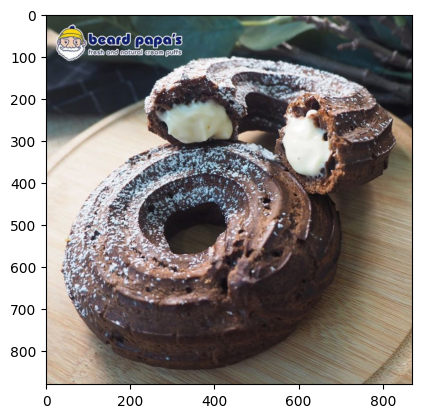

In [48]:
url = "https://raw.githubusercontent.com/UsagiUG/PCD_Assignment01/refs/heads/main/images/Screenshot.png"
url_img = Image.open(BytesIO(requests.get(url).content))

donut = np.array(url_img)
plt.imshow(donut)
plt.show()

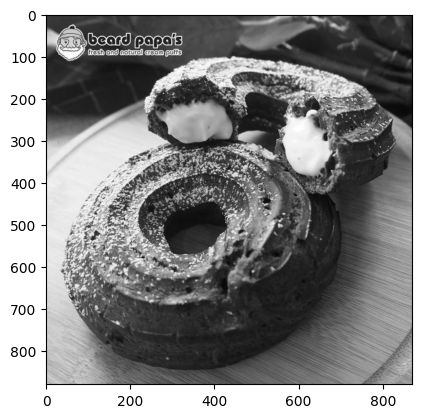

In [49]:
gs_donut = (donut[:,:,0]*0.299+donut[:,:,1]*0.587+donut[:,:,2]*0.114).astype(np.uint8)
plt.imshow(gs_donut, cmap="gray")
plt.show()

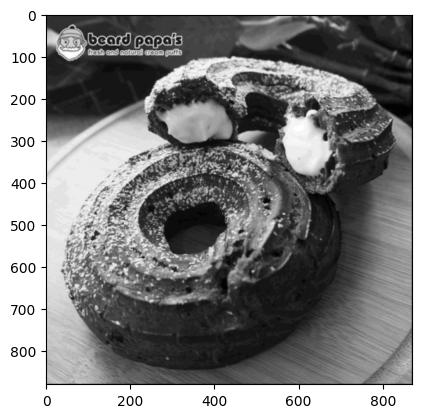

In [50]:
box_blur = (1/9) * np.ones((3, 3), dtype=np.float32)
box_blur_donut = convolution(gs_donut, box_blur)
plt.imshow(box_blur_donut, cmap="gray")
plt.show()

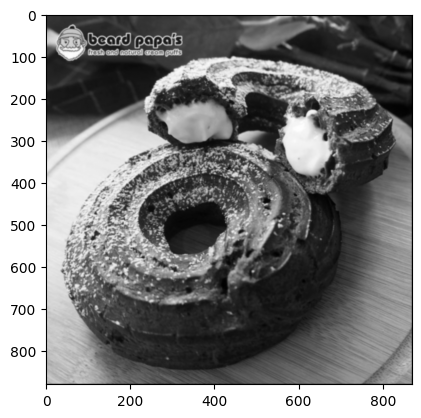

In [57]:
gaussian_blur = (1/273) * np.array([
        [1, 4, 7, 4, 1],
        [4,16,26,16, 4],
        [7,26,41,26, 7],
        [4,16,26,16, 4],
        [1, 4, 7, 4, 1]
    ], dtype=np.float32)
gaus_donut = convolution(gs_donut, gaussian_blur)
plt.imshow(gaus_donut, cmap="gray")
plt.show()

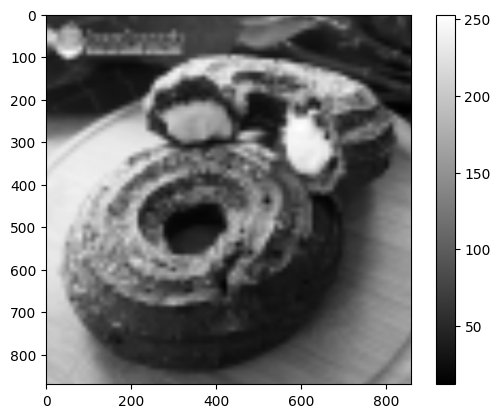

In [64]:
def resize(length1, length2, ratio):
  return round(length1 * ratio), round(length2 * ratio)

import math

#Calculating block-of-pixel's size to be processed.
#Use ceil() if the last block won't be out of bounds,
#else subtract 1 from the ceil()
def block_size(h, new_h, w, new_w):
  block_h = math.ceil(h / new_h)
  block_w = math.ceil(w / new_w)
  if block_h * (new_h - 1) >= h:
    block_h -= 1
  if block_w * (new_w - 1) >= w:
    block_w -= 1
  return block_h, block_w

def downsample(img, ratio, reduce_fn):
  h, w = img.shape[:2]
  new_h, new_w = resize(h, w, ratio)
  new_img = np.zeros((new_h, new_w, *img.shape[2:]), dtype=np.uint8)
  block_h, block_w = block_size(h, new_h, w, new_w)
  for j in range(new_h):
    for i in range(new_w):
      x = (i+1)*block_w if i < new_w-1 else w
      y = (j+1)*block_h if j < new_h-1 else h
      block = img[j*block_h:y, i*block_w:x]
      new_img[j,i] = reduce_fn(block, axis=(0,1))
  return new_img

mean_downsampled = downsample(gs_donut, 0.1, np.mean)
def bl_resize(h, w, ratio):
  return (h-1)*round(ratio), (w-1)*round(ratio)

def bl_upsample(img, ratio):
  h, w = img.shape[:2]
  new_h, new_w = bl_resize(h, w, ratio)
  ratio = round(ratio)
  new_img = np.zeros((new_h, new_w, *img.shape[2:]), dtype=np.uint8)
  # Last row and column trimmed, so h-1 and w-1
  for j in range(h-1):
    for i in range(w-1):
      x1, y1 = i*ratio, j*ratio
      x2, y2 = (i+1)*ratio, (j+1)*ratio
      divisor = 1 / ((x2-x1)*(y2-y1))
      neighbor_matrix = np.array([[img[j,i], img[j+1,i]],[img[j,i+1], img[j+1,i+1]]])
      for k in range(y1, y2):
        for l in range(x1, x2):
          row_vector = np.array([x2-l, l-x1])
          column_vector = np.array([[y2-k],[k-y1]])
          if img.ndim == 2:
            # For grayscale image
            new_img[k,l] = (divisor * row_vector @ neighbor_matrix @ column_vector).item()
          else:
            # For RGB
            for m in range(img.shape[2]):
              new_img[k,l,m] = (divisor * row_vector @ neighbor_matrix[:,:,m] @ column_vector).item()
  return new_img

bl_upsampled = bl_upsample(mean_downsampled, 10)
plt.imshow(bl_upsampled, cmap="gray")
plt.colorbar()
plt.show()

Sharpen

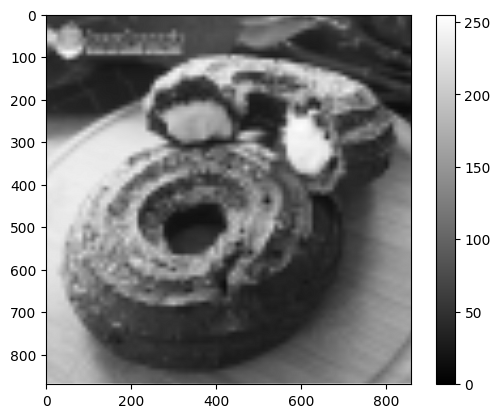

In [65]:
sharpen = np.array([[ 0, -1,  0],
                         [-1,  5, -1],
                         [ 0, -1,  0]], dtype=np.float32)
sharp_img = convolution(bl_upsampled, sharpen)
plt.imshow(sharp_img, cmap="gray")
plt.colorbar()
plt.show()

Pixel-based methods (Thresholding, contrast stretching) are good when the pixel's value is meaningful by itself. Convolutions are good when the pixel's meaning depends on its neighbors.